In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import patsy
from patsy import dmatrices

In [3]:
df_data = pd.read_excel('airlines.xlsx')
df_data.dropna(inplace=True)
assert df_data.isnull().sum().sum() == 0, "Nulls"

In [4]:
df_data['Date_of_Journey'] = pd.to_datetime(df_data['Date_of_Journey'])
df_data['Dep_Time'] = pd.to_datetime(df_data['Dep_Time'])
df_data['Arrival_Time'] = pd.to_datetime(df_data['Arrival_Time'])
df_data.dtypes

/var/folders/5z/779kcy4s2jn24846nws054w80000gn/T/ipykernel_48786/3861501485.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_data['Date_of_Journey'] = pd.to_datetime(df_data['Date_of_Journey'])
/var/folders/5z/779kcy4s2jn24846nws054w80000gn/T/ipykernel_48786/3861501485.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_data['Dep_Time'] = pd.to_datetime(df_data['Dep_Time'])
/var/folders/5z/779kcy4s2jn24846nws054w80000gn/T/ipykernel_48786/3861501485.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_data['Arrival_Time'] = pd.to_datetime(df_data['Arrival_Time'])


Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [5]:
df_data['Journey_day'] = df_data['Date_of_Journey'].dt.day
df_data['Journey_month'] = df_data['Date_of_Journey'].dt.month
df_data['Journey_year'] = df_data['Date_of_Journey'].dt.year
df_data['Dep_Time_hour'] = pd.to_datetime(df_data['Dep_Time'], format='%H:%M:%S').dt.hour
df_data['Dep_Time_minute'] = pd.to_datetime(df_data['Dep_Time'], format='%H:%M:%S').dt.minute
df_data['Arrival_Time_hour'] = pd.to_datetime(df_data['Arrival_Time'], format='%H:%M:%S').dt.hour
df_data['Arrival_Time_minute'] = pd.to_datetime(df_data['Arrival_Time'], format='%H:%M:%S').dt.minute

In [6]:
def departure_time(hour):
    if 4 <= hour < 8:
        return "Early Morning"
    elif 8 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 16:
        return "Noon"
    elif 16 <= hour < 20:
        return "Evening"
    elif 20 <= hour < 24:
        return "Night"
    else:
        return "Late Night"

df_data['dep_description'] = df_data['Dep_Time_hour'].apply(departure_time)

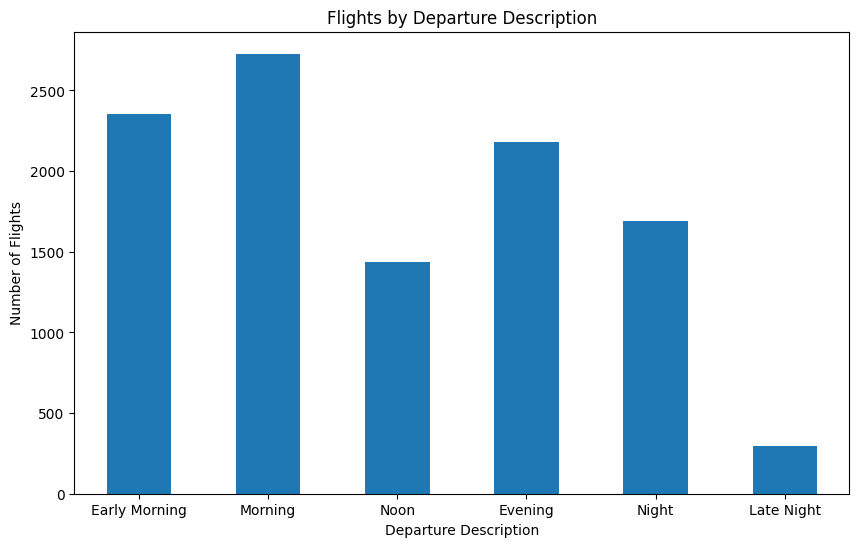

In [7]:
counts = df_data['dep_description'].value_counts().reindex(["Early Morning", "Morning", "Noon", "Evening", "Night", "Late Night"], fill_value=0)

plt.figure(figsize=(10,6))
counts.plot(kind='bar')
plt.title('Flights by Departure Description')
plt.xlabel('Departure Description')
plt.ylabel('Number of Flights')
plt.xticks(rotation=0)
plt.show()

In [8]:
def calculate(duration):
    hours, minutes = 0, 0
    if 'h' in duration:
        hours = int(duration.split('h')[0])
        duration = duration.split('h')[1]
    if 'm' in duration:
        minutes = int(duration.split('m')[0])
    return hours, minutes

df_data[['Duration_hours', 'Duration_mins']] = df_data['Duration'].apply(lambda x: pd.Series(calculate(x)))
df_data['Duration_total_mins'] = df_data['Duration_hours'] * 60 + df_data['Duration_mins']

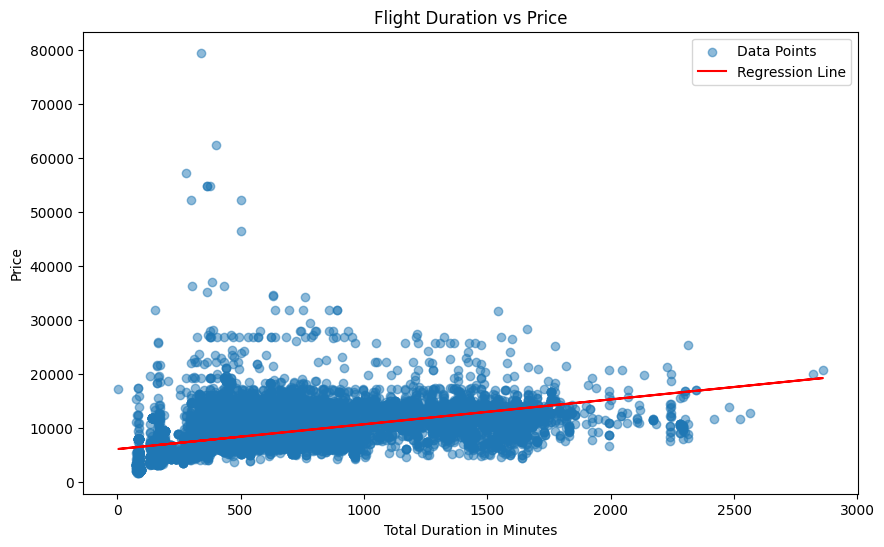

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(df_data['Duration_total_mins'], df_data['Price'], alpha=0.5, label='Data Points')

slope, intercept = np.polyfit(df_data['Duration_total_mins'], df_data['Price'], 1)
regression_line = slope * df_data['Duration_total_mins'] + intercept

plt.plot(df_data['Duration_total_mins'], regression_line, color='red', label='Regression Line')
plt.title('Flight Duration vs Price')
plt.xlabel('Total Duration in Minutes')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.show()

In [10]:
print(f"Regression line equation: Price = {slope:.2f} * Duration_total_mins + {intercept:.2f}")

Regression line equation: Price = 4.60 * Duration_total_mins + 6129.78


In [11]:
stops = df_data['Total_Stops'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(stops)))

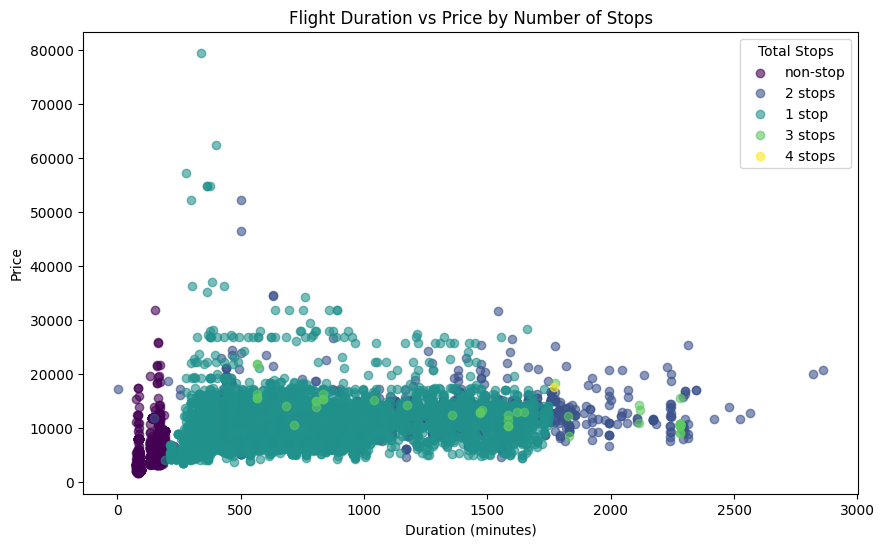

In [12]:
plt.figure(figsize=(10,6))
for stop, color in zip(stops, colors):
    subset = df_data[df_data['Total_Stops'] == stop]
    plt.scatter(subset['Duration_total_mins'], subset['Price'], label=stop, alpha=0.6, color=color)

plt.title('Flight Duration vs Price by Number of Stops')
plt.xlabel('Duration (minutes)')
plt.ylabel('Price')
plt.legend(title='Total Stops')
plt.show()

In [13]:
print("By incoporating colors, we can see just how large the distributions of flights with varying unique stops are, with the majority of them being only 1")

By incoporating colors, we can see just how large the distributions of flights with varying unique stops are, with the majority of them being only 1


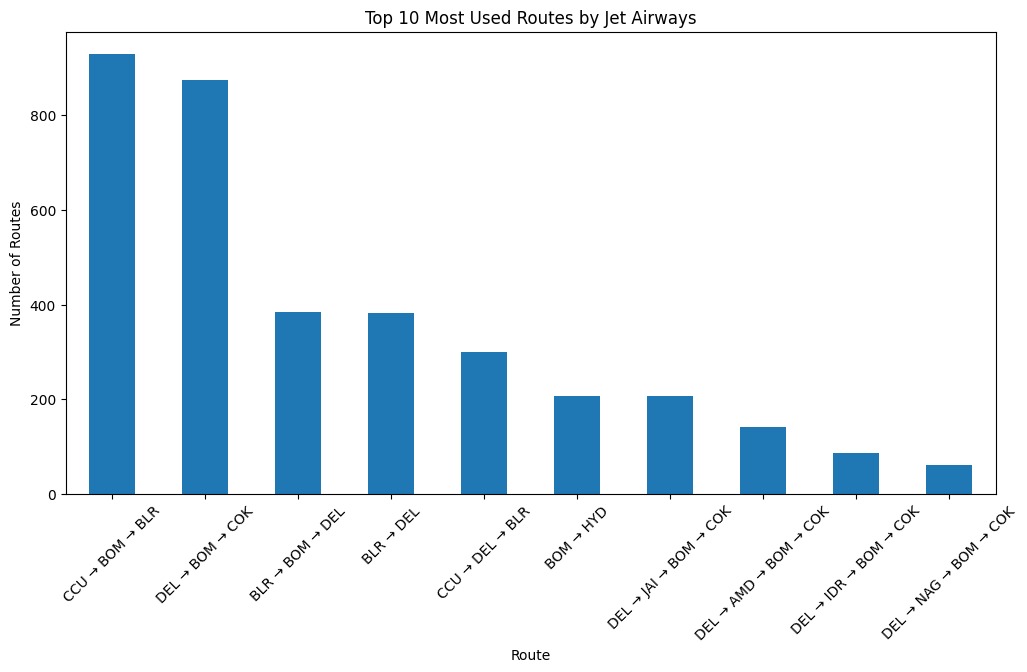

In [14]:
routes = df_data[df_data['Airline'] == 'Jet Airways']['Route'].value_counts().head(10)

plt.figure(figsize=(12,6))
routes.plot(kind='bar')
plt.title('Top 10 Most Used Routes by Jet Airways')
plt.xlabel('Route')
plt.ylabel('Number of Routes')
plt.xticks(rotation=45)
plt.show()

In [15]:
y, X = dmatrices('Price ~ Duration_total_mins -1', data=df_data, return_type='dataframe')
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f'R² score for Price ~ Duration_total_mins: {r2:.3f}')
#The R^2 score which I recieved was 0.257, or 0.26 rounded. This is a bit better than the result in scikit.ipynb, which was something around 0.16, but I'm sure this could be improved. It likely has to do with the nature of the data, and it being pretty inconsistent.


R² score for Price ~ Duration_total_mins: 0.257


In [16]:
matriceModel = dmatrices("Price ~ Airline * Source * Destination * Total_Stops * C(Journey_month) * Journey_day -1", data=df_data, return_type='dataframe')
x_train, x_test, y_train, y_test = train_test_split(matriceModel[1], matriceModel[0], test_size=0.20, random_state=42)
newModel = LinearRegression()
newModel.fit(x_train, y_train)
print('score', newModel.score(x_train, y_train))
print('coeff', newModel.coef_[0])
print('intercept', newModel.intercept_[0])

In [ ]:
alternative_formula = 'Price ~ Duration_total_mins + Airline + Source + Destination + Total_Stops -1' 
y, X = dmatrices(alternative_formula, data=df_data, return_type='dataframe')
alternative_model = LinearRegression()
alternative_model.fit(X, y)
y_pred_alternative = alternative_model.predict(X)
r2_alternative = r2_score(y, y_pred_alternative)
print(f'R² score for alternative model: {r2_alternative:.3f}')


#This result is much more accurate than the previous one, with my R^2 score reaching 0.6 as opposed to 0.25. 

R² score for alternative model: 0.601
